In [1]:
!pip install scikit-image
!pip install numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import sys

# Define the base path
base_path = './tibo1/project/Lab3/'
# Set the working directory to the project root
#os.chdir('./tibo1/project/Lab3/')

# Convert to absolute path and add to sys.path
sys.path.append(os.path.abspath(base_path))

In [3]:

import gzip
import pickle
import cv2
from skimage import filters
from typing import Tuple, List
from utils import uint2single, single2tensor4, test_onesplit, tensor2uint
import tqdm
import numpy as np
from tqdm import tqdm
from utils import get_device
from model import UNet

### 1. Pre-Definitions
#### 1a. Loader Function for the data

In [4]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
    return loaded_object

#### 1b. Utility Functions

In [13]:
def pad_image(image):
    h, w = image.shape
    target_size = max(h, w)
    padded_image = cv2.copyMakeBorder( #############WARNING NEED NUMPY==1.26.4
        image,
        0, target_size - h,
        0, target_size - w,
        cv2.BORDER_CONSTANT,
        value=0
    )

    return padded_image





def heal_image(img: np.ndarray):
    # Function to remove small artifacts from the image
    assert len(img.shape) == 2, "Image must be grayscale"
    height, width = img.shape
    ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_patch_size = 30
    for contour in contours:
        contour_area = cv2.contourArea(contour)
        if contour_area < min_patch_size:
            mask = np.zeros((height, width), np.uint8)
            cv2.drawContours(mask, [contour], 0, 255, -1)
            img = cv2.inpaint(img, mask, 2, cv2.INPAINT_TELEA)
    return img


def denoise_enhance_image(image: np.ndarray, model, noise_level_model_tensor, device,
                          denoise_before: bool) -> np.ndarray:
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4, 4))
    if denoise_before:
        image = denoise_image(image, model, noise_level_model_tensor, device)
        image = clahe.apply(image)
    else:
        image = clahe.apply(image)
        image = denoise_image(image, model, noise_level_model_tensor, device)
    image = heal_image(image)
    return image


def process_image(image: np.ndarray, target_size: Tuple[int, int], model, noise_level_model_tensor, device,
                  is_test: bool = False, denoise_before: bool = False) -> np.ndarray:
    assert len(image.shape) == 2, 'Image must be grayscale'
    # Pad image to create square aspect ratio

    padded_image = pad_image(image)
    # TODO SHOULD WE ALSO DENOISE TEST OR NOT
    if not is_test:
        padded_image = denoise_enhance_image(
            padded_image, model, noise_level_model_tensor, device, denoise_before
        )
    # Resize image to target size
    resized = cv2.resize(padded_image, target_size, interpolation=cv2.INTER_LINEAR)
    return resized


def process_box(box, target_size):
    # box is currently boolean, convert it to uint8
    # Convert to uint8 (if not already)
    box_uint8 = box.astype(np.uint8)

    # Pad the box to maintain aspect ratio
    padded_box = pad_image(box_uint8)

    # Resize the box
    resized = cv2.resize(padded_box, target_size, interpolation=cv2.INTER_LINEAR)

    # Re-binarize to ensure clean 0s and 1s
    binary_box = (resized > 0.5).astype(np.uint8)
    return binary_box


def process_mask(mask: np.ndarray, target_size: Tuple[int, int]) -> np.ndarray:
    assert len(mask.shape) == 2, 'Mask must be grayscale'
    # Pad image to create square aspect ratio
    padded_mask = pad_image(mask)
    # Apply bilateral filter
    padded_mask = cv2.bilateralFilter(padded_mask, d=9, sigmaColor=1, sigmaSpace=1)
    # Threshold the filtered image
    threshold_value = filters.threshold_otsu(padded_mask)
    padded_mask = (padded_mask > threshold_value * 2).astype(np.uint8) * 255  # Threshold
    # Dilate the filtered image
    kernel = np.ones((2, 2), np.uint8)
    padded_mask = cv2.dilate(padded_mask, kernel, iterations=1)
    # Apply Gaussian blur to the dilated and filtered image
    padded_mask = cv2.GaussianBlur(padded_mask, (3, 3), 2)
    padded_mask = (padded_mask > threshold_value).astype(np.uint8) * 255
    # Resize image to target size
    resized = cv2.resize(padded_mask, target_size, interpolation=cv2.INTER_LINEAR)
    return resized


#### 1c. Load DRUNet model

In [6]:
import torch
# Load the pre-trained DRUNet model
from drunet.drunet import UNetRes


def load_drunet_model(model_path: str, device: str = 'cpu'):
    print("Running on device: ", device)
    n_channels = 1
    noise_level_model = 5
    noise_level_model_tensor = torch.FloatTensor([noise_level_model / 255.]).to(device)

    model = UNetRes(
        in_nc=n_channels + 1,
        out_nc=n_channels,
        nc=[64, 128, 256, 512],
        nb=4,
        act_mode='R',
        downsample_mode="strideconv",
        upsample_mode="convtranspose"
    )
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True), strict=True)
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    model = model.to(device)
    return model, noise_level_model_tensor


def denoise_image(image: np.ndarray, model, noise_level_model_tensor, device) -> np.ndarray:
    image = np.expand_dims(image, axis=2)
    image = uint2single(image)
    image = single2tensor4(image)

    # Ensure the noise_level_model_tensor is on the same device as the input
    noise_level_model_tensor = noise_level_model_tensor.to(device)
    image = image.to(device)  # Move image to the correct device

    image = torch.cat((
        image,
        noise_level_model_tensor.repeat(1, 1, image.shape[2], image.shape[3])
    ), dim=1)
    image = image.to(device)
    denoised_img = test_onesplit(model, image, refield=32)
    denoised_img = tensor2uint(denoised_img)
    return denoised_img

### 2. Preprocess Data
#### 2.a Load Data

In [7]:
# Paths to your data files
train_data_path = './data/train.pkl'
test_data_path = './data/test.pkl'

# Load the data
train_data = load_zipped_pickle(train_data_path)
test_data = load_zipped_pickle(test_data_path)

print(f'Loaded {len(train_data)} patients from training data.')
print(f'Loaded {len(test_data)} patients from test data.')

Loaded 65 patients from training data.
Loaded 20 patients from test data.


#### 2.b Initialize the DRUNet model

In [8]:
# Path to the pretrained DRUNet model
drunet_model_path = './drunet/drunet_gray.pth'
device = get_device()
print(f'Running on device: {device}')

# Load the model
drunet_model, noise_level_model_tensor = load_drunet_model(drunet_model_path, device)
TARGET_SIZE = (224, 224)  # Adjust as needed currently 2 times amateur samples dim

Running on device: cuda
Running on device:  cuda


#### 2.c Preprocess Training Data
##### Separate Amateur and Expert Data

In [9]:
# Separate amateur and expert data
amateur_data = [patient for patient in train_data if patient['dataset'] == 'amateur']
expert_data = [patient for patient in train_data if patient['dataset'] == 'expert']

print(f'Expert data: {len(expert_data)} patients')
print(f'Amateur data: {len(amateur_data)} patients')

Expert data: 19 patients
Amateur data: 46 patients


##### Process Images and Masks

In [10]:
def preprocess_dataset(data: List[dict], target_size: Tuple[int, int], drunet_model, noise_level_model_tensor, device,
                       is_test: bool = False):
    print("Running on device: ", device)
    total_frames = 0

    for i, patient in enumerate(tqdm(data, desc=f'Processing {"Test" if is_test else "Train"} Data: ')):
        video = patient['video']

        if not is_test:
            masks = patient['label']
            frames = patient['frames']

            # Process images
            new_video = [
                process_image(
                    video[..., frame].astype(np.uint8),
                    target_size,
                    drunet_model,
                    noise_level_model_tensor,
                    device,
                    is_test=False,
                    denoise_before=False
                )
                for frame in range(video.shape[-1])
            ]

            new_video = np.array(new_video) / 255.0  # Normalize images

            new_box = process_box(patient['box'], target_size)

            new_masks = [
                process_mask(masks[..., frame].astype(np.uint8), target_size)
                for frame in range(masks.shape[-1])]
            new_masks = np.array(new_masks).astype(np.float32)

            patient['video'] = new_video
            patient['box'] = new_box
            patient['label'] = new_masks

        else:
            # Test data processing (no masks)
            new_video = [
                process_image(
                    video[..., frame].astype(np.uint8),
                    target_size,
                    drunet_model,
                    noise_level_model_tensor,
                    device,
                    is_test=True,
                    denoise_before=False
                )
                for frame in range(video.shape[-1])
            ]
            new_video = np.array(new_video) / 255.0  # Normalize images

            patient['video'] = new_video

        total_frames += new_video.shape[0]

        if i % 5 == 0:
            print(f"Processed {i + 1}/{len(data)} patients. Total frames so far: {total_frames}")

    print("Finished preprocessing and bootstrapping.")
    return data, total_frames

In [14]:
preprocessed_expert_data, expert_total_frames = preprocess_dataset(expert_data, TARGET_SIZE, drunet_model,
                                                                   noise_level_model_tensor, device, is_test=False)
preprocessed_amateur_data, amateur_total_frames = preprocess_dataset(amateur_data, TARGET_SIZE, drunet_model,
                                                                     noise_level_model_tensor, device, is_test=False)

Running on device:  cuda


Processing Train Data:   5%|▌         | 1/19 [00:11<03:19, 11.07s/it]

Processed 1/19 patients. Total frames so far: 76


Processing Train Data:  32%|███▏      | 6/19 [01:44<04:29, 20.69s/it]

Processed 6/19 patients. Total frames so far: 513


Processing Train Data:  58%|█████▊    | 11/19 [02:53<01:59, 14.91s/it]

Processed 11/19 patients. Total frames so far: 893


Processing Train Data:  84%|████████▍ | 16/19 [04:41<01:00, 20.23s/it]

Processed 16/19 patients. Total frames so far: 1424


Processing Train Data: 100%|██████████| 19/19 [05:56<00:00, 18.75s/it]


Finished preprocessing and bootstrapping.
Running on device:  cuda


Processing Train Data:   2%|▏         | 1/46 [00:06<04:31,  6.02s/it]

Processed 1/46 patients. Total frames so far: 334


Processing Train Data:  13%|█▎        | 6/46 [00:23<02:28,  3.71s/it]

Processed 6/46 patients. Total frames so far: 1307


Processing Train Data:  24%|██▍       | 11/46 [00:36<01:33,  2.67s/it]

Processed 11/46 patients. Total frames so far: 2047


Processing Train Data:  35%|███▍      | 16/46 [00:52<01:27,  2.92s/it]

Processed 16/46 patients. Total frames so far: 2906


Processing Train Data:  46%|████▌     | 21/46 [01:10<01:26,  3.46s/it]

Processed 21/46 patients. Total frames so far: 3875


Processing Train Data:  57%|█████▋    | 26/46 [01:24<01:00,  3.05s/it]

Processed 26/46 patients. Total frames so far: 4676


Processing Train Data:  67%|██████▋   | 31/46 [01:40<00:45,  3.01s/it]

Processed 31/46 patients. Total frames so far: 5550


Processing Train Data:  78%|███████▊  | 36/46 [01:57<00:32,  3.22s/it]

Processed 36/46 patients. Total frames so far: 6489


Processing Train Data:  89%|████████▉ | 41/46 [02:11<00:14,  2.93s/it]

Processed 41/46 patients. Total frames so far: 7267


Processing Train Data: 100%|██████████| 46/46 [02:28<00:00,  3.22s/it]

Processed 46/46 patients. Total frames so far: 8170
Finished preprocessing and bootstrapping.


In [15]:
np.save('./out/preprocessed6bis/preprocessed_expert_data.npy', preprocessed_expert_data)
np.save('./out/preprocessed6bis/expert_total_frames.npy', expert_total_frames)
np.save('./out/preprocessed6bis/preprocessed_amateur_data.npy', preprocessed_amateur_data)
np.save('./out/preprocessed6bis/amateur_total_frames.npy', amateur_total_frames)

In [16]:
preprocessed_test_data, _ = preprocess_dataset(test_data, TARGET_SIZE, drunet_model, noise_level_model_tensor, device, is_test=True)
np.save('./out/preprocessed6bis/preprocessed_test_data.npy', preprocessed_test_data)

Running on device:  cuda


Processing Test Data:   5%|▌         | 1/20 [00:00<00:02,  7.96it/s]

Processed 1/20 patients. Total frames so far: 103


Processing Test Data:  30%|███       | 6/20 [00:00<00:00, 15.66it/s]

Processed 6/20 patients. Total frames so far: 422


Processing Test Data:  70%|███████   | 14/20 [00:01<00:00, 12.82it/s]

Processed 11/20 patients. Total frames so far: 873


Processing Test Data:  90%|█████████ | 18/20 [00:01<00:00, 12.86it/s]

Processed 16/20 patients. Total frames so far: 1225


Processing Test Data: 100%|██████████| 20/20 [00:01<00:00, 13.37it/s]


Finished preprocessing and bootstrapping.


In [ ]:
import matplotlib.pyplot as plt
import random

def plot_expert_data_with_masks(data, num_videos=5):
    """
    Plot 5 randomly chosen videos, one frame per video where a mask exists.
    Each row contains:
        - Column 1: Original frame
        - Column 2: Frame + True Mask + True Box
    """
    fig, axes = plt.subplots(num_videos, 2, figsize=(12, 3 * num_videos))  # 2 columns

    for i in range(num_videos):
        # Randomly select a video
        video_idx = random.randint(0, len(data) - 1)
        video_data = data[video_idx]
        
        # Get a frame index where a mask exists
        mask_indices = video_data['frames']  # Indices where masks exist
        idx = random.choice(mask_indices)  # Randomly select one valid frame index

        # Extract data for the chosen frame
        video_frame = video_data['video'][idx]
        true_mask = video_data['label'][idx]
        true_box = video_data['box']

        # Plot Original Frame (Column 1)
        axes[i, 0].imshow(video_frame, cmap='gray')
        axes[i, 0].set_title(f"Video {video_idx}, Frame {idx}")
        axes[i, 0].axis('off')

        # Plot Frame + Mask + Box (Column 2)
        axes[i, 1].imshow(video_frame, cmap='gray')
        axes[i, 1].imshow(true_mask, cmap='viridis', alpha=0.5)  # Overlay true mask
        axes[i, 1].imshow(true_box, cmap='jet', alpha=0.3)       # Overlay true box
        axes[i, 1].set_title("Mask + Box")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

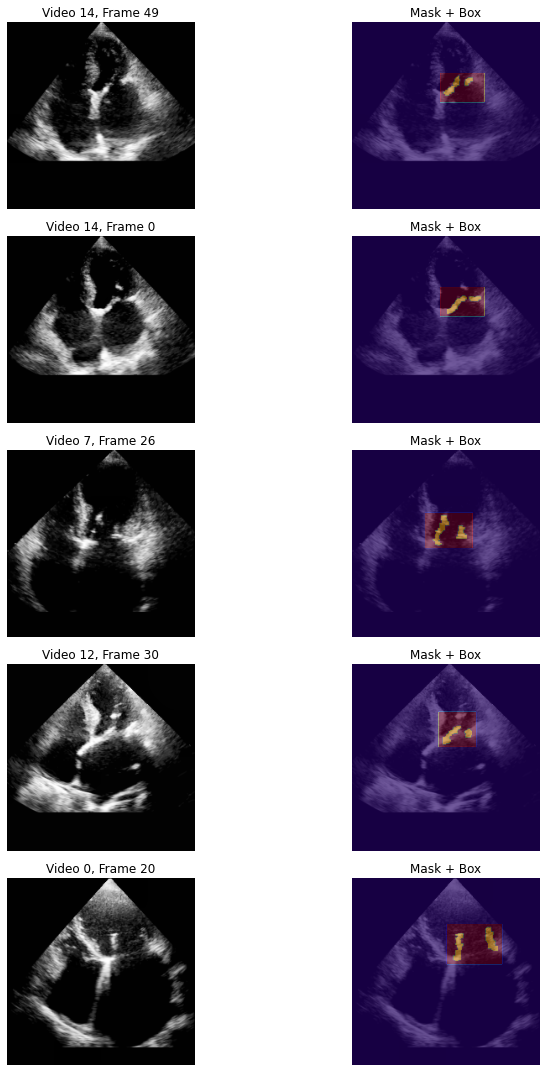

In [ ]:
plot_expert_data_with_masks(preprocessed_expert_data)

In [19]:
# free gpu memory
del drunet_model
del noise_level_model_tensor
import gc
gc.collect()

32743